In [ ]:
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import numpy as np
import csv
import math
import os

import matplotlib.pyplot as plt

### Import Dataset

In [ ]:
## ToTensor transfor image to pytorch tensor, here auto trasfor pixel [0, 255] to [0.0, 1.0]
## Normalize transfor normalize image data, aiming to transform the pixel values of images to a distribution with specified means and standard deviations
## There are actually two tuples, each containing three values, corresponding to the three color channels of an image (red, green, blue): The first tuple (0.5, 0.5, 0.5) specifies the target mean The second tuple (0.5, 0.5, 0.5) specifies the target standard deviation for each color channel.
## After ToTensor and Normalize pixel value will transfor from [0, 255] to [-1.0, 1.0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### batch_size
batch_size = 12


# Load training data
# shuffle to avoid overfitting which is common setting for training model
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Load testing data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29046322.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
## output the shape of the input sample
for images, labels in trainloader:
    print(images.shape) # [batch_size, channels, height, width] -> torch.Size([4, 3, 32, 32])
    print(labels.shape) # [batch_size] -> torch.Size([4])
    break

torch.Size([12, 3, 32, 32])
torch.Size([12])


### Visualize dataset

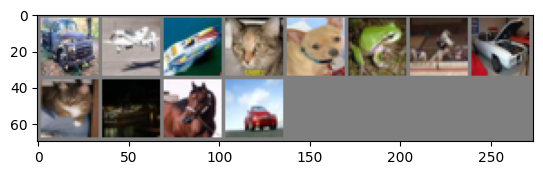

truck plane ship  cat   dog   frog  horse car   cat   ship  horse car  


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to [0.0, 1.0]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # torch shaoe is [channels, height, width], change in to [height, width, channels] for visualize
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Resize images for use with MobileNetV2

In [ ]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2
# Able to use torchvision.transforms
# Update the transform to resize images to 96x96 for MobileNetV2
transform = transforms.Compose([
    transforms.Resize(96),  # MobileNetV2 requires at least 96x96
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Reload the datasets with the updated transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


### Download MobileNetV2 model



In [ ]:
#<Write code for downloading MobileNetV2>
# Download the pre-trained MobileNetV2 model
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 168MB/s]


### Remove the final output layer

In [ ]:
#<Write code to Remove the final output layer>
# Remove the final classification layer (assuming it's the last layer in the classifier)
mobilenet_v2.classifier[1] = torch.nn.Identity()


### Add custom layers at the end of downloaded model

In [ ]:
#<Write code for adding custom layers>
# Load the pre-trained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Get the number of input features for the last layer
num_features = mobilenet_v2.classifier[1].in_features

# Remove the last layer
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_features, 512),  # First hidden layer with 512 nodes
    nn.ReLU(),                     # ReLU activation function
    nn.Dropout(p=0.5),             # Dropout layer for regularization

    # Final output layer with 10 nodes for CIFAR-10 classes
    # Since CIFAR-10 has 10 classes, the output layer must have 10 nodes
    nn.Linear(512, 10),
    # No softmax here since it will be included in the loss function during training
)


### Add loss function, compile and train the model, and check accuracy on test data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
#<Write code>
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = mobilenet_v2.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Variables for tracking the best model
best_model_wts = copy.deepcopy(mobilenet_v2.state_dict())
best_acc = 0.0

num_epochs = 25

target_test_accuracy = 0.85  # 85%
epoch_losses = []

for epoch in range(num_epochs):
    mobilenet_v2.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Training phase
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_v2(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()  # Update the learning rate scheduler

    # Calculate training accuracy for the epoch
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_losses.append(epoch_loss)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)

    # Test phase
    mobilenet_v2.eval()  # Set the model to evaluation mode
    test_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = mobilenet_v2(inputs)
            _, preds = torch.max(outputs, 1)
            test_running_corrects += torch.sum(preds == labels.data)

    # Calculate test accuracy
    test_acc = test_running_corrects.double() / len(testloader.dataset)
    print(f'Epoch {epoch}/{num_epochs - 1} - Loss: {epoch_loss:.4f}, Train Acc: {running_corrects.double()/len(trainloader.dataset):.4f}, Test Acc: {test_acc:.4f}')

    # Checkpointing
    if epoch_acc > best_acc:
        print(f'Saving new best model with accuracy: {epoch_acc:.4f}')
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(mobilenet_v2.state_dict())
        torch.save({
            'epoch': epoch,
            'model_state_dict': mobilenet_v2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc,
        }, 'checkpoint_mobilenet_v2_cifar10.pth')

    # Early stopping condition
    if test_acc >= target_test_accuracy:
        print(f'Test accuracy reached target threshold of {target_test_accuracy:.2f}. Stopping training.')
        break
# Load best model weights
mobilenet_v2.load_state_dict(best_model_wts)

# Evaluate on test data
mobilenet_v2.eval()
running_corrects = 0
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = mobilenet_v2(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(testloader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 0/24 - Loss: 1.1176, Train Acc: 0.6319, Test Acc: 0.7230
Saving new best model with accuracy: 0.6319
Epoch 1/24 - Loss: 0.8200, Train Acc: 0.7377, Test Acc: 0.8162
Saving new best model with accuracy: 0.7377
Epoch 2/24 - Loss: 0.6913, Train Acc: 0.7782, Test Acc: 0.8170
Saving new best model with accuracy: 0.7782
Epoch 3/24 - Loss: 0.6047, Train Acc: 0.8060, Test Acc: 0.8388
Saving new best model with accuracy: 0.8060
Epoch 4/24 - Loss: 0.5460, Train Acc: 0.8259, Test Acc: 0.8475
Saving new best model with accuracy: 0.8259
Epoch 5/24 - Loss: 0.4926, Train Acc: 0.8405, Test Acc: 0.8442
Saving new best model with accuracy: 0.8405
Epoch 6/24 - Loss: 0.4555, Train Acc: 0.8539, Test Acc: 0.8561
Saving new best model with accuracy: 0.8539
Epoch 7/24 - Loss: 0.2651, Train Acc: 0.9139, Test Acc: 0.8886
Saving new best model with accuracy: 0.9139
Epoch 8/24 - Loss: 0.2046, Train Acc: 0.9329, Test Acc: 0.8925
Saving new best model with accuracy: 0.9329


KeyboardInterrupt: 

1) Write how you extended the MobileNetV2 model

Added a custom classifier to the pre-trained MobileNetV2 Model. This classifier consists of 2 layers. The first layer is a fully connected (dense) layer with 512 nodes and uses a ReLU activation function for non-linearity. To help with regularization and prevent overfitting, a dropout layer with a dropout rate of 0.5 follows the first dense layer. The second layer is also a fully connected layer with 10 nodes which corresponds to the 10 classes of the CIFAR - 10 dataset. This layer does not have an activation function as the softmax function is applied through the loss function during training.

2) Plot the loss function value with respect to the epoch number on the training data. How did you decide when to terminate training? How did you decide the mini-batch size for training?

- Terminated training based on early stop condition when test accuracy reached target threshold of 85%.
- Batch size is determined based on trial and error (attempted 4,8 which lead to optimal size of 12).

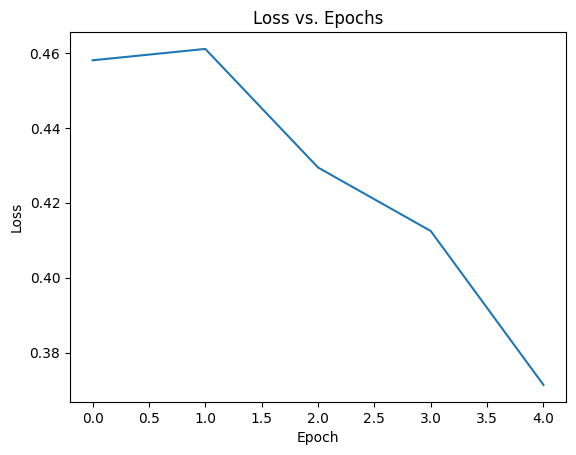

In [ ]:
# Plotting the loss values
plt.plot(epoch_losses)
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

3) Show accuracy of the trained classifier over the entire testing dataset.

86.20%

### Extra code for producing different plots